# Notebook 3 — Patches 32×32, Balanceamento e CNN (mini-MIAS)

Este notebook continua o pipeline após o **Notebook 2 (equalização)**.

## Objetivos
1. **Carregar** as imagens **equalizadas** (ou pré-processadas) e seus metadados;
2. **Extrair patches** de tamanho **32×32** com `stride` configurável, usando a máscara para evitar fundo;
3. **Atribuir rótulos** por `SEVERITY` (Normal/Benign/Malignant) a partir do `preprocess_manifest.csv`;
4. **Balancear** o dataset por classe usando **undersampling** até o tamanho da classe minoritária;
5. **Split por REFNUM** (70/15/15) para evitar *data leakage* entre patches da mesma imagem;
6. **Treinar uma CNN** simples (Keras) e **avaliar** com Accuracy, Precision, Recall, F1 e **matriz de confusão**.

### Pré-requisitos
- Notebook 1: `outputs_preproc/` existente (imagens e máscaras)
- Notebook 2: `outputs_eq/<modo>/` existente com as equalizações ou usar as pré-processadas
- `outputs_preproc/preprocess_manifest.csv` gerado


In [1]:
# ==== Configurações principais ====
from pathlib import Path

BASE_DIR = Path('.')
PREPROC_DIR = BASE_DIR / 'outputs_preproc'
PREPROC_IMG_DIR = PREPROC_DIR / 'images'
PREPROC_MSK_DIR = PREPROC_DIR / 'masks'
PREPROC_MANIFEST = PREPROC_DIR / 'preprocess_manifest.csv'

# Use um dos modos abaixo gerados pelo Notebook 2, ou defina None para usar imagens pré-processadas
EQUALIZATION_MODE = 'clahe_test6'   # opções: 'hiw_test1','hiw_test2','hiw_test3','clahe_test5','clahe_test6' ou None
EQ_DIR = BASE_DIR / 'outputs_eq' / EQUALIZATION_MODE if EQUALIZATION_MODE else None

# Extração de patches
PATCH_SIZE = 32
STRIDE = 32   # 16 para overlaps
MASK_MIN_FRACTION = 0.6  # fração mínima de pixels da mama dentro do patch

# Split por REFNUM (evita vazamento)
SPLIT = {'train': 0.70, 'val': 0.15, 'test': 0.15}
RANDOM_SEED = 42

# Treino
BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-3

print('Usando equalização:', EQUALIZATION_MODE)

Usando equalização: clahe_test6


In [4]:
# ==== Imports ====
import os, re, glob, random
import numpy as np
import pandas as pd
import cv2
from skimage import io
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [5]:
# ==== Utilidades ====
def read_gray_float01(path: Path):
    img = io.imread(path)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = img.astype(np.float32)
    if img.max() > 1:
        img = img / 255.0
    return np.clip(img, 0.0, 1.0)

def extract_refnum(filename:str):
    base = os.path.basename(filename).lower()
    m = re.search(r"(mdb\d{3})", base)
    return m.group(1) if m else os.path.splitext(base)[0]

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def as_uint8(img):
    return (np.clip(img, 0, 1) * 255 + 0.5).astype(np.uint8)


## 1) Carregar manifest e decidir a origem das imagens
- Se `EQUALIZATION_MODE` for definido, vamos ler as imagens em `outputs_eq/<modo>/`.
- Caso contrário, usaremos as imagens pré-processadas em `outputs_preproc/images/`.
- Para filtrar patches, usamos a **máscara** correspondente de `outputs_preproc/masks/`.

In [6]:
assert PREPROC_MANIFEST.is_file(), f"Manifest não encontrado: {PREPROC_MANIFEST}"
meta = pd.read_csv(PREPROC_MANIFEST)

# Ajusta REFNUM para minúsculas
meta['REFNUM'] = meta['REFNUM'].astype(str).str.lower()

# Seleciona apenas colunas relevantes
cols = ['REFNUM','output_img','output_mask','SEVERITY','DENSITY','CLASS','CLASS_GROUP']
for c in cols:
    if c not in meta.columns:
        meta[c] = np.nan
meta = meta[cols]

print('Linhas no manifest:', len(meta))
meta.head(3)

Linhas no manifest: 644


,REFNUM,output_img,output_mask,SEVERITY,DENSITY,CLASS,CLASS_GROUP
0,mdb001,outputs_preproc\images\mdb001_preproc.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
1,mdb001,outputs_preproc\images\mdb001_preproc.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
2,mdb002,outputs_preproc\images\mdb002_preproc.png,outputs_preproc\masks\mdb002_mask.png,Benign,B,CIRC,Masses


## 2) Montar lista de caminhos de imagem de **entrada do modelo**
Se houver equalização escolhida, substituímos o caminho da imagem pelo arquivo correspondente em `outputs_eq/<modo>/` mantendo o `REFNUM` no nome.

In [7]:
def eq_path_for_ref(refnum: str, mode: str):
    if not mode:
        return None
    # Saída do Notebook 2 salva como: <ref>_<modo>.png (onde <ref> é stem sem _preproc)
    # Ex.: mdb001_clahe_test6.png
    return (EQ_DIR / f"{refnum}_{mode}.png")

def build_records(meta_df: pd.DataFrame, mode: str):
    recs = []
    for _, row in meta_df.iterrows():
        ref = row['REFNUM']
        mask_path = Path(row['output_mask']) if isinstance(row['output_mask'], str) else None
        if mode:
            img_path = eq_path_for_ref(ref, mode)
        else:
            # usa a pré-processada
            img_path = Path(str(row['output_img']).replace('_preproc.png', '_preproc.png'))
        recs.append({
            'REFNUM': ref,
            'img_path': str(img_path) if img_path else None,
            'mask_path': str(mask_path) if mask_path else None,
            'SEVERITY': row['SEVERITY'],
            'DENSITY': row['DENSITY'],
            'CLASS': row['CLASS'],
            'CLASS_GROUP': row['CLASS_GROUP'],
        })
    df = pd.DataFrame(recs)
    # Mantém somente registros existentes em disco
    df = df[df['img_path'].apply(lambda p: Path(p).is_file())]
    df = df[df['mask_path'].apply(lambda p: Path(p).is_file())]
    return df

df_img = build_records(meta, EQUALIZATION_MODE)
print('Imagens utilizáveis:', len(df_img))
df_img.head(3)

Imagens utilizáveis: 644


,REFNUM,img_path,mask_path,SEVERITY,DENSITY,CLASS,CLASS_GROUP
0,mdb001,outputs_eq\clahe_test6\mdb001_clahe_test6.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
1,mdb001,outputs_eq\clahe_test6\mdb001_clahe_test6.png,outputs_preproc\masks\mdb001_mask.png,Benign,B,CIRC,Masses
2,mdb002,outputs_eq\clahe_test6\mdb002_clahe_test6.png,outputs_preproc\masks\mdb002_mask.png,Benign,B,CIRC,Masses


## 3) Extração de patches 32×32
- Deslizamos janelas 32×32 com `stride` definido;
- Filtramos por **máscara** (mínimo `MASK_MIN_FRACTION` de pixels da mama dentro do patch);
- Atribuímos o rótulo de **SEVERITY** do `REFNUM`.

> Dica: você pode ajustar `STRIDE` (ex.: 16) para aumentar a amostra, mantendo o split por REFNUM para não vazar entre conjuntos.

In [8]:
def extract_patches_from_image(img, msk, patch=32, stride=32, mask_min_fraction=0.6):
    H, W = img.shape
    patches = []
    for y in range(0, H - patch + 1, stride):
        for x in range(0, W - patch + 1, stride):
            roi = img[y:y+patch, x:x+patch]
            rmask = msk[y:y+patch, x:x+patch]
            if rmask.mean() >= mask_min_fraction:
                patches.append((roi, (y, x)))
    return patches

records = []
for _, r in df_img.iterrows():
    img = read_gray_float01(Path(r['img_path']))
    msk = read_gray_float01(Path(r['mask_path']))
    msk = (msk > 0.5).astype(np.float32)
    pts = extract_patches_from_image(img, msk, PATCH_SIZE, STRIDE, MASK_MIN_FRACTION)
    for roi, (yy, xx) in pts:
        records.append({
            'REFNUM': r['REFNUM'],
            'SEVERITY': r['SEVERITY'],
            'patch': roi.astype(np.float32),
        })

df_patches = pd.DataFrame(records)
print('Total de patches extraídos:', len(df_patches))
df_patches['SEVERITY'].value_counts(dropna=False)

Total de patches extraídos: 452326


SEVERITY
Normal                                                                                         291920
Benign                                                                                          83180
Malignant                                                                                       67248
REFNUM\nmdb249    Malignant\nmdb249    Malignant\nName: SEVERITY, dtype: object                  1710
REFNUM\nmdb144       Benign\nmdb144    Malignant\nName: SEVERITY, dtype: object                  1630
REFNUM\nmdb005    Benign\nmdb005    Benign\nName: SEVERITY, dtype: object                        1616
REFNUM\nmdb239    Malignant\nmdb239    Malignant\nName: SEVERITY, dtype: object                  1536
REFNUM\nmdb226    Benign\nmdb226    Benign\nmdb226    Benign\nName: SEVERITY, dtype: object      1280
REFNUM\nmdb223    Benign\nmdb223    Benign\nName: SEVERITY, dtype: object                        1190
REFNUM\nmdb132    Benign\nmdb132    Benign\nName: SEVERITY, dtype: object

## 4) Split por REFNUM e balanceamento por classe
- Split estratificado **por imagem** (REFNUM) em 70/15/15;
- Em seguida, **undersampling** no nível de **patches** para igualar as classes ao **mínimo** disponível.

In [9]:
from collections import defaultdict

# Mapeia cada REFNUM para sua classe (SEVERITY)
ref2label = df_patches.groupby('REFNUM')['SEVERITY'].agg(lambda s: s.iloc[0]).to_dict()

# Lista de REFNUM por classe
by_class_refs = defaultdict(list)
for ref, lab in ref2label.items():
    by_class_refs[str(lab)].append(ref)

train_refs, val_refs, test_refs = set(), set(), set()
rng = np.random.RandomState(RANDOM_SEED)
for lab, refs in by_class_refs.items():
    refs = sorted(refs)
    rng.shuffle(refs)
    n = len(refs)
    n_train = int(SPLIT['train'] * n)
    n_val = int(SPLIT['val'] * n)
    train_refs.update(refs[:n_train])
    val_refs.update(refs[n_train:n_train+n_val])
    test_refs.update(refs[n_train+n_val:])

def subset_by_refs(df, refs):
    return df[df['REFNUM'].isin(refs)].copy()

train_df = subset_by_refs(df_patches, train_refs)
val_df   = subset_by_refs(df_patches, val_refs)
test_df  = subset_by_refs(df_patches, test_refs)

print('Patches por split (antes do balanceamento):')
print('train:', train_df['SEVERITY'].value_counts(dropna=False).to_dict())
print('val  :', val_df['SEVERITY'].value_counts(dropna=False).to_dict())
print('test :', test_df['SEVERITY'].value_counts(dropna=False).to_dict())

def undersample_to_min(df, label_col='SEVERITY'):
    counts = df[label_col].value_counts()
    if len(counts) == 0:
        return df
    min_count = counts.min()
    parts = []
    for lab, c in counts.items():
        part = df[df[label_col] == lab].sample(min_count, random_state=RANDOM_SEED)
        parts.append(part)
    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)
    return out

train_df_bal = undersample_to_min(train_df)
val_df_bal   = undersample_to_min(val_df)
test_df_bal  = undersample_to_min(test_df)

print('\nPatches por split (após balanceamento):')
print('train:', train_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())
print('val  :', val_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())
print('test :', test_df_bal['SEVERITY'].value_counts(dropna=False).to_dict())

Patches por split (antes do balanceamento):
train: {'Normal': 203358, 'Benign': 57138, 'Malignant': 47842}
val  : {'Normal': 43672, 'Benign': 12132, 'Malignant': 9170}
test : {'Normal': 44890, 'Benign': 13910, 'Malignant': 10236, 'REFNUM\nmdb249    Malignant\nmdb249    Malignant\nName: SEVERITY, dtype: object': 1710, 'REFNUM\nmdb144       Benign\nmdb144    Malignant\nName: SEVERITY, dtype: object': 1630, 'REFNUM\nmdb005    Benign\nmdb005    Benign\nName: SEVERITY, dtype: object': 1616, 'REFNUM\nmdb239    Malignant\nmdb239    Malignant\nName: SEVERITY, dtype: object': 1536, 'REFNUM\nmdb226    Benign\nmdb226    Benign\nmdb226    Benign\nName: SEVERITY, dtype: object': 1280, 'REFNUM\nmdb223    Benign\nmdb223    Benign\nName: SEVERITY, dtype: object': 1190, 'REFNUM\nmdb132    Benign\nmdb132    Benign\nName: SEVERITY, dtype: object': 1016}

Patches por split (após balanceamento):
train: {'Malignant': 47842, 'Benign': 47842, 'Normal': 47842}
val  : {'Benign': 9170, 'Malignant': 9170, 'Normal

## 5) Preparar tensores e rótulos (LabelEncoder)

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

def clean_severity(v):
    # Caso seja uma Series/array/objeto com iloc, pega o primeiro elemento
    if hasattr(v, "iloc"):
        try:
            v = v.iloc[0]
        except Exception:
            v = str(v)
    if isinstance(v, (list, tuple, np.ndarray)):
        v = v[0] if len(v) else ""
    # string pura, sem quebras de linha / rótulos anexos
    v = str(v)
    v = v.replace("\n", " ").strip()
    # normaliza capitalização e mapeia variações
    vl = v.lower()
    if "normal" in vl:
        return "Normal"
    if "benign" in vl:   # pega 'benign'/'benigno'
        return "Benign"
    if "malig" in vl:    # pega 'malig'/'malignant'/'maligno'
        return "Malignant"
    # fallback
    return v or "Unknown"

# 2) Aplica limpeza nos três splits ANTES de treinar o encoder
for _df in [train_df_bal, val_df_bal, test_df_bal]:
    _df["SEVERITY"] = _df["SEVERITY"].apply(clean_severity).astype(str)

# 3) Treina o encoder só com as classes presentes no TREINO
le = LabelEncoder()
le.fit(train_df_bal["SEVERITY"].values)
n_classes = len(le.classes_)
print("Classes (ordem do encoder):", list(le.classes_))

le = LabelEncoder()
le.fit(train_df_bal['SEVERITY'].astype(str).values)
n_classes = len(le.classes_)
print('Classes (ordem do encoder):', list(le.classes_))

def df_to_xy(df):
    # Garante que haverá ao menos 1 amostra antes de empilhar
    if len(df) == 0:
        return np.empty((0, PATCH_SIZE, PATCH_SIZE, 1), dtype=np.float32), np.empty((0,), dtype=np.int64)
    X = np.stack(df['patch'].values).astype(np.float32)
    X = X[..., np.newaxis]  # (N, 32, 32, 1)
    y = le.transform(df['SEVERITY'].astype(str).values)
    return X, y

X_train, y_train = df_to_xy(train_df_bal)
X_val,   y_val   = df_to_xy(val_df_bal)
X_test,  y_test  = df_to_xy(test_df_bal)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)

Classes (ordem do encoder): ['Benign', 'Malignant', 'Normal']
Classes (ordem do encoder): ['Benign', 'Malignant', 'Normal']
Shapes: (143526, 32, 32, 1) (27510, 32, 32, 1) (10160, 32, 32, 1)


## 6) CNN simples (Keras)

In [17]:
def build_cnn(input_shape=(32,32,1), n_classes=3):
    m = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

model = build_cnn(input_shape=(PATCH_SIZE,PATCH_SIZE,1), n_classes=n_classes)
model.summary()

c:\Users\jhter\OneDrive - cefet-rj.br\Processamento-Imagem\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,331 (1.36 MB)

 Trainable params: 355,331 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

### Treino

In [18]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.3342 - loss: 1.0988 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 2/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.3308 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 3/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.3322 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 4/20
2242/2243 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3340 - loss: 1.0986
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.3320 - loss: 1.0987 - val_accuracy: 0.3333 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 5/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.3325 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 5.0000e-04
Epoch 6/20
2243/2243 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accu

## 7) Avaliação — métricas e matriz de confusão

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Relatório de classificação (por patches):
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00      6096
   Malignant       0.30      1.00      0.46      3048
      Normal       0.00      0.00      0.00      1016

    accuracy                           0.30     10160
   macro avg       0.10      0.33      0.15     10160
weighted avg       0.09      0.30      0.14     10160

Matriz de confusão (ordem dos rótulos = encoder):
[[   0 6096    0]
 [   0 3048    0]
 [   0 1016    0]]


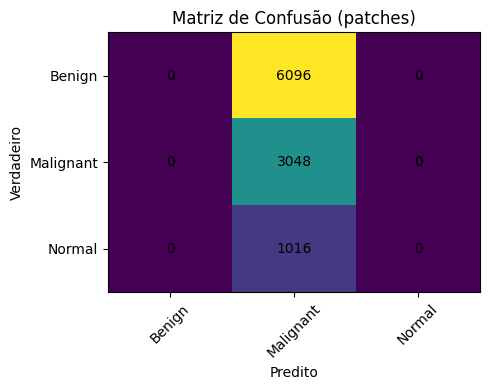

In [19]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
y_hat = np.argmax(y_pred, axis=1)

# Para evitar erro quando alguma classe não aparece no y_test,
# fixamos o conjunto de labels e target_names de acordo com o encoder
all_labels = np.arange(n_classes)
all_names  = list(le.classes_)

print('Relatório de classificação (por patches):')
print(classification_report(
    y_test, y_hat,
    labels=all_labels,
    target_names=all_names,
    zero_division=0  # evita warnings/erros de divisão por zero
))

# Matriz de confusão com eixo fixo (inclui classes ausentes no teste)
cm = confusion_matrix(y_test, y_hat, labels=all_labels)
print('Matriz de confusão (ordem dos rótulos = encoder):')
print(cm)

# Plot da matriz (sem especificar cores)
plt.figure(figsize=(5,4))
plt.imshow(cm, aspect='auto')
plt.title('Matriz de Confusão (patches)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks(ticks=all_labels, labels=all_names, rotation=45)
plt.yticks(ticks=all_labels, labels=all_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.tight_layout()
plt.show()

## 8) Observações
- O artigo reporta métricas por **conjuntos de imagens** e também efeitos por **grupos de lesões**; aqui avaliamos por **patches**. Se quiser, agregue por **imagem** (voto da maioria dos patches) para aproximar do nível de imagem;
- Ajuste `STRIDE` para controlar o nº de patches. `16` tende a aumentar o dataset, mas mantenha o split por **REFNUM**;
- Para usar **outra equalização**, altere `EQUALIZATION_MODE` (conforme Notebook 2);
- Você pode trocar a CNN por uma arquitetura um pouco maior (BatchNorm, mais camadas) para tentar reproduzir os números do paper;
- Caso queira estratificar por **DENSITY**/`BI-RADS`, basta filtrar `df_img`/`df_patches` antes de extrair os conjuntos.